In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
from sklearn import metrics

In [3]:
from tensorflow import keras

In [4]:
import sys

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
sys.path.append('../')

In [7]:
import datatools

In [8]:
import importlib

In [9]:
from glob import glob

## Load Data

In [10]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/"
DATA_LOC=f"{SIM}/20220628/atlas_mm_vmm_bkgr_1_TEST/*.h5"

files=glob(DATA_LOC)

print(len(files))

200


In [11]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=500, sort_by='z')

/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation//20220628/atlas_mm_vmm_bkgr_1_TEST/NoMuon.atlas_mm_vmm.nevs_1000.bkgr_1_Rnd138474.h5
['is_muon', 'x', 'y', 'z', 'ptype', 'ptilt', 'poffset', 'time', 'projX_at_rightend_x', 'projX_at_rightend_y', 'projX_at_middle_x', 'projX_at_middle_y', 'projY_at_topend_x', 'projY_at_topend_y', 'projY_at_middle_x', 'projY_at_middle_y', 'seg_ix', 'rdrift']
/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation//20220628/atlas_mm_vmm_bkgr_1_TEST/WithMuon.atlas_mm_vmm.nevs_1000.bkgr_1.mux.-14.0.14.0_Rnd176519.h5
/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation//20220628/atlas_mm_vmm_bkgr_1_TEST/NoMuon.atlas_mm_vmm.nevs_1000.bkgr_1_Rnd138468.h5
/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation//20220628/atlas_mm_vmm_bkgr_1_TEST/WithMuon.atlas_mm_vmm.nevs_1000.bkgr_1.mux.-14.0.14.0_Rnd176503.h5
/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation//20220628/atlas_mm_vmm_bkgr_1_TEST/WithMuon.atlas_mm_vmm.nevs_1000.bkgr_1.mux.-14.0.14.0_Rnd176

In [12]:
data.keys()

dict_keys(['ev_mu_phi', 'ev_mu_theta', 'ev_mu_time', 'ev_mu_x', 'ev_mu_y', 'ev_n_mu_signals', 'ev_n_signals', 'n_sig_mmx', 'n_sig_mmu', 'n_sig_mmv'])

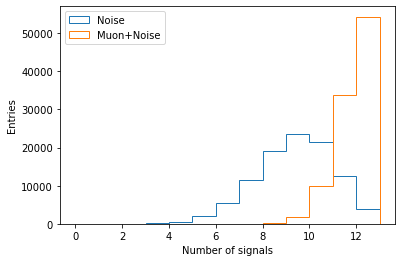

In [13]:
plt.Figure()
plt.hist(data['ev_n_signals'][Y_mu==0], histtype='step', range=(0,13), bins=13, label='Noise')
plt.hist(data['ev_n_signals'][Y_mu==1], histtype='step', range=(0,13), bins=13, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of signals')
plt.ylabel('Entries')
plt.show()

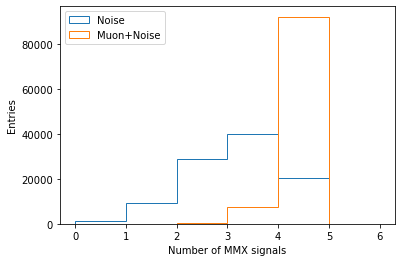

In [14]:
plt.Figure()
h_noise = plt.hist(data['n_sig_mmx'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
h_muons = plt.hist(data['n_sig_mmx'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMX signals')
plt.ylabel('Entries')
plt.show()

In [15]:
for ib in range(0,7):
    sig_eff = h_muons[0][ib:].sum()/h_muons[0].sum()
    bkg_rej = 1./(h_noise[0][ib:].sum()/h_noise[0].sum())
    print('Minimum number of MMX signals:', ib)
    print('\t', 'Signal efficiency:', sig_eff)
    print('\t', 'Background rejection:', bkg_rej)

Minimum number of MMX signals: 0
	 Signal efficiency: 1.0
	 Background rejection: 1.0
Minimum number of MMX signals: 1
	 Signal efficiency: 1.0
	 Background rejection: 1.0118897040222616
Minimum number of MMX signals: 2
	 Signal efficiency: 0.99993
	 Background rejection: 1.1185181871057224
Minimum number of MMX signals: 3
	 Signal efficiency: 0.99778
	 Background rejection: 1.6559307158588483
Minimum number of MMX signals: 4
	 Signal efficiency: 0.92229
	 Background rejection: 4.927079227433977
Minimum number of MMX signals: 5
	 Signal efficiency: 0.0
	 Background rejection: inf
Minimum number of MMX signals: 6
	 Signal efficiency: 0.0
	 Background rejection: inf


<ipython-input-15-927cb1fc27ea>:3: RuntimeWarning: divide by zero encountered in double_scalars
  bkg_rej = 1./(h_noise[0][ib:].sum()/h_noise[0].sum())


In [16]:
h_noise

(array([ 1175.,  9421., 29015., 40093., 20296.,     0.]),
 array([0., 1., 2., 3., 4., 5., 6.]),
 [<matplotlib.patches.Polygon at 0x7fc431726c70>])

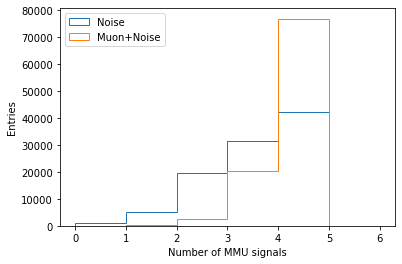

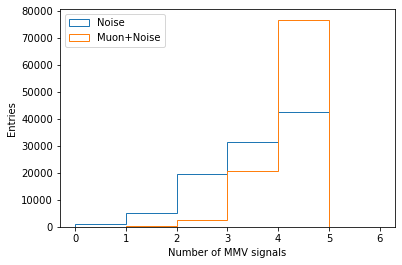

In [17]:
plt.Figure()
plt.hist(data['n_sig_mmu'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
plt.hist(data['n_sig_mmu'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMU signals')
plt.ylabel('Entries')
plt.show()

plt.Figure()
plt.hist(data['n_sig_mmv'][Y_mu==0], histtype='step', range=(0,6), bins=6, label='Noise')
plt.hist(data['n_sig_mmv'][Y_mu==1], histtype='step', range=(0,6), bins=6, label='Muon+Noise')
plt.legend(loc='upper left')
plt.xlabel('Number of MMV signals')
plt.ylabel('Entries')
plt.show()

In [18]:
import trainingvariables

In [19]:
X_prep = datatools.training_prep(dmat, sig_keys)

In [20]:
vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
training_vars = trainingvariables.tvars
for tv in training_vars:
    vars_of_interest[sig_keys.index(tv)] = 1
X = X_prep[:,:,vars_of_interest]

## Load Model and Evaluate

In [21]:
%ls -lhrt ../models/

total 50K
drwxr-sr-x 4 rafaeltl at 8.0K Jun 28 08:08 gru_BatchNormTrue_MaskingFalse_28062022_06.21.52/
drwxr-sr-x 4 rafaeltl at 4.0K Jun 28 11:22 lstm_BatchNormTrue_MaskingFalse_28062022_10.27.00/
drwxr-sr-x 4 rafaeltl at 4.0K Jun 28 23:35 gru_BatchNormFalse_MaskingFalse_28062022_06.00.14/
drwxr-sr-x 4 rafaeltl at 8.0K Jun 29 01:18 lstm_BatchNormFalse_MaskingFalse_29062022_00.09.58/
drwxr-sr-x 4 rafaeltl at 8.0K Jun 29 02:21 gru_BatchNormFalse_MaskingFalse_29062022_01.20.50/


In [22]:
model_loc = '../models/'
model_name = 'lstm_BatchNormFalse_MaskingFalse_29062022_00.09.58'
# model_name = 'attn_deepsets_27062022_08.40.27'

In [23]:
model = keras.models.load_model(model_loc+model_name)

In [24]:
yhat = model.predict(X, batch_size=1024)

In [25]:
yhat_x3 = np.copy(yhat)
yhat_x3[data['n_sig_mmx']<4] = 0.0

yhat_x2 = np.copy(yhat)
yhat_x2[data['n_sig_mmx']<3] = 0.0

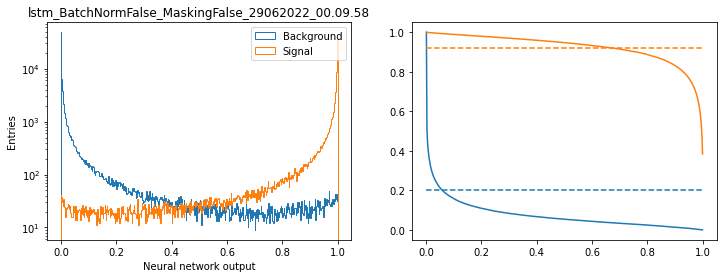

In [26]:
ncols, nrows = (2,1)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
axs = axs.flatten()

h_b = axs[0].hist(yhat[Y_mu==0], histtype='step', range=(0,1), bins=500, label='Background')
h_s = axs[0].hist(yhat[Y_mu==1], histtype='step', range=(0,1), bins=500, label='Signal')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_xlabel('Neural network output')
axs[0].set_ylabel('Entries')
axs[0].set_title(model_name)

xaxs = 0.5*( h_b[1][1:] + h_b[1][:-1] )
axs[1].plot(xaxs, h_b[0][::-1].cumsum()[::-1]/h_b[0].sum(), label='B efficiency')
axs[1].plot(xaxs, h_s[0][::-1].cumsum()[::-1]/h_s[0].sum(), label='S efficiency')
axs[1].plot([0,1], [1/4.927079227433977, 1/4.927079227433977], '--', color='C0')
axs[1].plot([0,1], [0.92229, 0.92229], '--', color='C1')

plt.savefig(model_loc+model_name+'/output_histogram.pdf')
plt.show()

<ipython-input-27-4bb92761e5ae>:6: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label='Cut on NN')
<ipython-input-27-4bb92761e5ae>:7: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr_x3, 1./fpr_x3, label=r'Cut on NN & $N_{MMX} > 3$')
<ipython-input-27-4bb92761e5ae>:8: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr_x2, 1./fpr_x2, label=r'Cut on NN & $N_{MMX} > 2$')


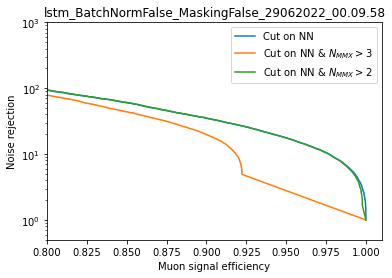

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(Y_mu, yhat)
fpr_x3, tpr_x3, thresholds = metrics.roc_curve(Y_mu, yhat_x3)
fpr_x2, tpr_x2, thresholds = metrics.roc_curve(Y_mu, yhat_x2)

plt.Figure()
plt.semilogy(tpr, 1./fpr, label='Cut on NN')
plt.semilogy(tpr_x3, 1./fpr_x3, label=r'Cut on NN & $N_{MMX} > 3$')
plt.semilogy(tpr_x2, 1./fpr_x2, label=r'Cut on NN & $N_{MMX} > 2$')
plt.xlim(0.8, 1.01)
plt.ylim(0.5, 1e3)
plt.xlabel('Muon signal efficiency')
plt.ylabel('Noise rejection')
plt.legend()
plt.title(model_name)
plt.savefig(model_loc+model_name+'/roc.pdf')
plt.show()

## Try chi2 line fit

In [28]:
import linefit

In [29]:
lfits = linefit.get_fits(dmat, sig_keys)

/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/21062022/si-mu-lator/algorithms/notebooks/../linefit.py:25: RuntimeWarning: invalid value encountered in double_scalars
  A = ( _c5*_c2 - _c3*_c4 ) / ( _c2**2 - _c1*_c4 )
/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/21062022/si-mu-lator/algorithms/notebooks/../linefit.py:25: RuntimeWarning: divide by zero encountered in double_scalars
  A = ( _c5*_c2 - _c3*_c4 ) / ( _c2**2 - _c1*_c4 )
/gpfs/slac/atlas/fs1/u/rafaeltl/Muon/21062022/si-mu-lator/algorithms/notebooks/../linefit.py:29: RuntimeWarning: invalid value encountered in add
  Chi2 = ( ( A*zs + B - xs )**2 / unc_xs**2 ).sum()


In [30]:
nn_cut_same_bkg_eff = 0.1
nn_cut_same_sig_eff = 0.7

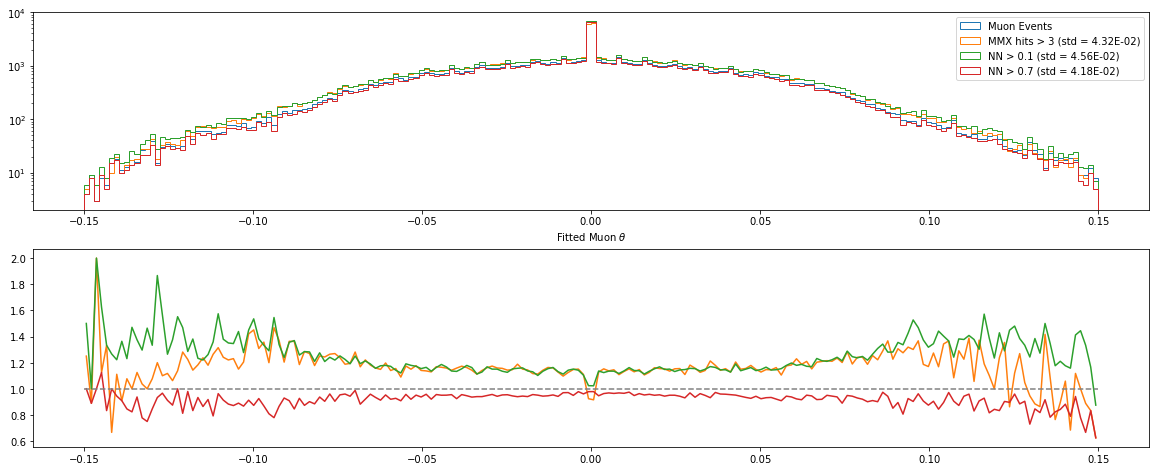

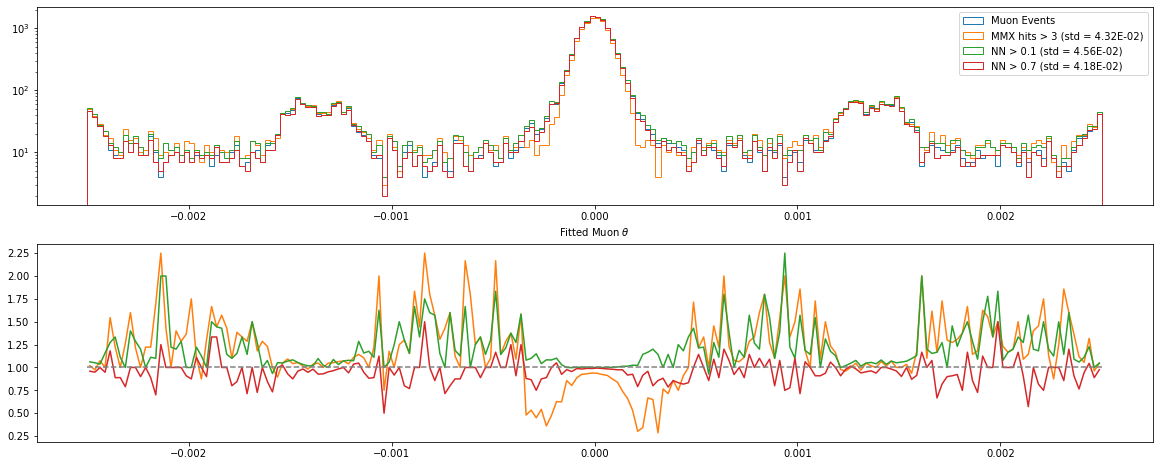

In [31]:
ncols, nrows = (1,2)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,4*nrows))
axs = axs.flatten()

h0 = axs[0].hist( lfits[:,0][Y_mu==1], histtype='step', density=0, bins=200, range=(-0.15, 0.15),label='Muon Events' )

v = lfits[:,0][(data['n_sig_mmx']>3)]
h1 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-0.15, 0.15),label=f'MMX hits > 3 (std = {v.std():.2E})' )

v = lfits[:,0][(yhat.flatten()>nn_cut_same_bkg_eff)]
h2 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-0.15, 0.15),label=f'NN > {nn_cut_same_bkg_eff} (std = {v.std():.2E})' )

v = lfits[:,0][(yhat.flatten()>nn_cut_same_sig_eff)]
h3 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-0.15, 0.15),label=f'NN > {nn_cut_same_sig_eff} (std = {v.std():.2E})' )

axs[0].set_xlabel(r'Fitted Muon $\theta$')
axs[0].legend()
axs[0].set_yscale('log')

xaxs = 0.5*( h0[1][1:] + h0[1][:-1] )

axs[1].plot(xaxs, h1[0]/h0[0], color='C1')
axs[1].plot(xaxs, h2[0]/h0[0], color='C2')
axs[1].plot(xaxs, h3[0]/h0[0], color='C3')
axs[1].plot([-0.15, 0.15], [1,1], '--', color='gray')

plt.show()

ncols, nrows = (1,2)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,4*nrows))
axs = axs.flatten()

h0 = axs[0].hist( lfits[:,0][Y_mu==1], histtype='step', density=0, bins=200, range=(-0.0025, 0.0025),label='Muon Events' )

v = lfits[:,0][(data['n_sig_mmx']>3)]
h1 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-0.0025, 0.0025),label=f'MMX hits > 3 (std = {v.std():.2E})' )

v = lfits[:,0][(yhat.flatten()>nn_cut_same_bkg_eff)]
h2 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-0.0025, 0.0025),label=f'NN > {nn_cut_same_bkg_eff} (std = {v.std():.2E})' )

v = lfits[:,0][(yhat.flatten()>nn_cut_same_sig_eff)]
h3 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-0.0025, 0.0025),label=f'NN > {nn_cut_same_sig_eff} (std = {v.std():.2E})' )

axs[0].set_xlabel(r'Fitted Muon $\theta$')
axs[0].legend()
axs[0].set_yscale('log')

xaxs = 0.5*( h0[1][1:] + h0[1][:-1] )

axs[1].plot(xaxs, h1[0]/h0[0], color='C1')
axs[1].plot(xaxs, h2[0]/h0[0], color='C2')
axs[1].plot(xaxs, h3[0]/h0[0], color='C3')
axs[1].plot([-0.0025, 0.0025], [1,1], '--', color='gray')

plt.show()

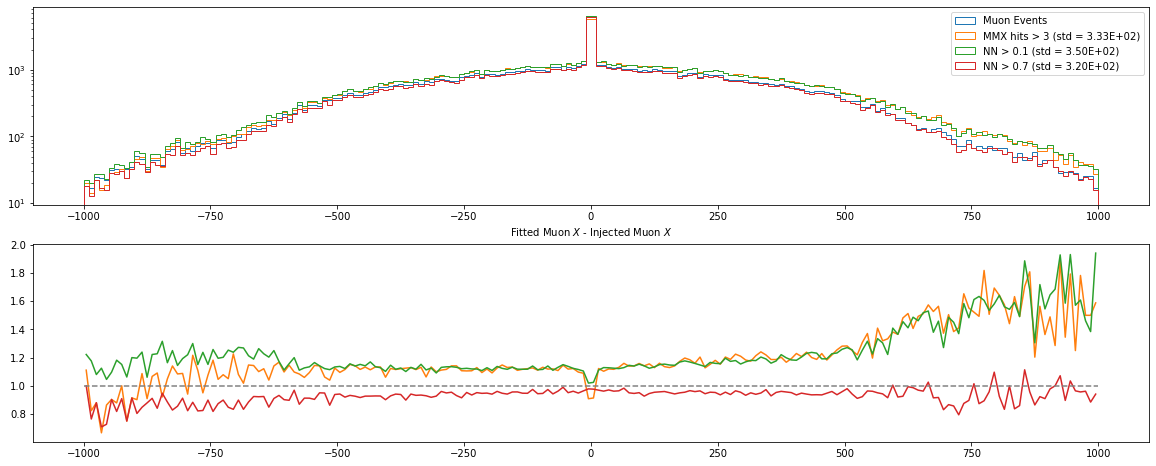

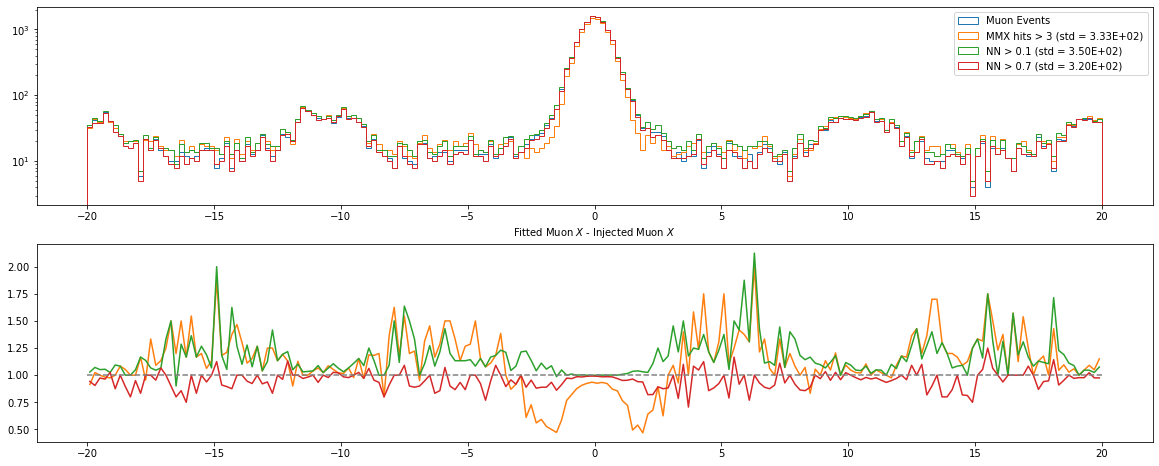

In [32]:
ncols, nrows = (1,2)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,4*nrows))
axs = axs.flatten()

h0 = axs[0].hist( lfits[:,1][Y_mu==1] - data['ev_mu_x'][Y_mu==1], 
                 histtype='step', density=0, bins=200, range=(-1000, 1000),label='Muon Events' )

v = lfits[:,1][(data['n_sig_mmx']>3)] - data['ev_mu_x'][data['n_sig_mmx']>3]
h1 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-1000, 1000),label=f'MMX hits > 3 (std = {v.std():.2E})' )

v = lfits[:,1][(yhat.flatten()>nn_cut_same_bkg_eff)] - data['ev_mu_x'][yhat.flatten()>nn_cut_same_bkg_eff]
h2 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-1000, 1000),label=f'NN > {nn_cut_same_bkg_eff} (std = {v.std():.2E})' )

v = lfits[:,1][(yhat.flatten()>nn_cut_same_sig_eff)] - data['ev_mu_x'][yhat.flatten()>nn_cut_same_sig_eff]
h3 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-1000, 1000),label=f'NN > {nn_cut_same_sig_eff} (std = {v.std():.2E})' )

axs[0].set_xlabel(r'Fitted Muon $X$ - Injected Muon $X$')
axs[0].legend()
axs[0].set_yscale('log')

xaxs = 0.5*( h0[1][1:] + h0[1][:-1] )

axs[1].plot(xaxs, h1[0]/h0[0], color='C1')
axs[1].plot(xaxs, h2[0]/h0[0], color='C2')
axs[1].plot(xaxs, h3[0]/h0[0], color='C3')
axs[1].plot([-1000, 1000], [1,1], '--', color='gray')

plt.show()

ncols, nrows = (1,2)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,4*nrows))
axs = axs.flatten()

h0 = axs[0].hist( lfits[:,1][Y_mu==1] - data['ev_mu_x'][Y_mu==1], 
                 histtype='step', density=0, bins=200, range=(-20, 20),label='Muon Events' )

v = lfits[:,1][(data['n_sig_mmx']>3)] - data['ev_mu_x'][data['n_sig_mmx']>3]
h1 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-20, 20),label=f'MMX hits > 3 (std = {v.std():.2E})' )

v = lfits[:,1][(yhat.flatten()>nn_cut_same_bkg_eff)] - data['ev_mu_x'][yhat.flatten()>nn_cut_same_bkg_eff]
h2 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-20, 20),label=f'NN > {nn_cut_same_bkg_eff} (std = {v.std():.2E})' )

v = lfits[:,1][(yhat.flatten()>nn_cut_same_sig_eff)] - data['ev_mu_x'][yhat.flatten()>nn_cut_same_sig_eff]
h3 = axs[0].hist( v, histtype='step',density=0, bins=200, range=(-20, 20),label=f'NN > {nn_cut_same_sig_eff} (std = {v.std():.2E})' )

axs[0].set_xlabel(r'Fitted Muon $X$ - Injected Muon $X$')
axs[0].legend()
axs[0].set_yscale('log')

xaxs = 0.5*( h0[1][1:] + h0[1][:-1] )

axs[1].plot(xaxs, h1[0]/h0[0], color='C1')
axs[1].plot(xaxs, h2[0]/h0[0], color='C2')
axs[1].plot(xaxs, h3[0]/h0[0], color='C3')
axs[1].plot([-20, 20], [1,1], '--', color='gray')

plt.show()